# Variational Auto-encoder

This notebook presents a variational auto-encoder ([paper](https://arxiv.org/abs/1312.6114)) for trajectory generation.

In [1]:
import altair as alt

from deep_traffic_generation.tc_vae import TCVAE
from deep_traffic_generation.core.datasets import TrafficDataset

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import numpy as np

from traffic.core.projection import EuroPP

import torch

from deep_traffic_generation.core.utils import traffic_from_data

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(42)
np.random.seed(42)

In [2]:
dataset = TrafficDataset.from_file(
    "../deep_traffic_generation/data/traffic_15.pkl",
    features=["latitude", "longitude", "altitude", "timedelta"],
    scaler=MinMaxScaler(feature_range=(-1,1)),
    shape="image",
)
dataset

Dataset TrafficDataset
    Number of datapoints: 3968
    MinMaxScaler(feature_range=(-1, 1))

In [3]:
model = TCVAE.load_from_checkpoint(
    "../deep_traffic_generation/lightning_logs/tc_vae/version_2/checkpoints/epoch=2912-step=8738.ckpt",
    hparams_file="../deep_traffic_generation/lightning_logs/tc_vae/version_2/hparams.yaml",
    x_dim=dataset.input_dim,
    seq_len=dataset.seq_len,
    scaler=dataset.scaler,
    navpts=dataset.navpts,
)
model.eval()

TCVAE(
  (encoder): TCEncoder(
    (encoder): Sequential(
      (0): TCN(
        (network): Sequential(
          (0): ResidualBlock(
            (tmp_block1): TemporalBlock(
              (conv): Conv1d(4, 16, kernel_size=(16,), stride=(1,))
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (tmp_block2): TemporalBlock(
              (conv): Conv1d(16, 16, kernel_size=(16,), stride=(1,))
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (downsample): Conv1d(4, 16, kernel_size=(1,), stride=(1,))
          )
          (1): ResidualBlock(
            (tmp_block1): TemporalBlock(
              (conv): Conv1d(16, 16, kernel_size=(16,), stride=(1,), dilation=(2,))
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (tmp_block2): TemporalBlock(
              (conv): Conv1d(16, 16, kernel_size=(16,), stride=(1,), dilation=(2,))
              (dropout): Dropout(p=0.0, inplace=False)
            )
       

In [4]:
z, _ = model.encoder(torch.Tensor(dataset.dense))
x = z.detach().cpu().numpy()
# z_scale = np.exp(z_scale.detach().cpu().numpy() / 2)
x.shape

(3968, 32)

### Reconstruction

In [5]:
original, _, info = dataset[0]
_, reconstruction = model(original.unsqueeze(0))

data = np.concatenate((original.unsqueeze(0).numpy(), reconstruction.detach().numpy()))
data = np.transpose(data, (0, 2, 1))
data.shape

(2, 200, 4)

In [6]:
data = data.reshape(data.shape[0], -1)
data = dataset.scaler.inverse_transform(data)
data.shape

(2, 800)

In [7]:
# info = info.repeat(2, 1)
# info.size()

In [8]:
# add latitude longitude info
# data = np.concatenate((info.numpy(), data), axis=1)
print(data.shape)
builder = model.get_builder(data.shape[0])
features = [
    "track" if "track" in f else f for f in model.hparams.features
]
traffic = traffic_from_data(
    data, features, model.hparams.init_features, builder=builder
)
traffic

(2, 800)


,count
flight_id,
0,200
1,200


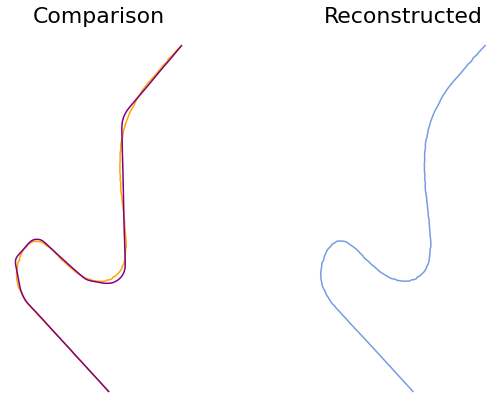

In [9]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=EuroPP()))
    ax[0].set_title("Comparison")
    traffic[1].plot(ax[0], c="orange", label="reconstructed")
    traffic[0].plot(ax[0], c="purple", label="original")
    ax[1].set_title("Reconstructed")
    traffic[1].plot(ax[1])

    plt.show()

In [10]:
traffic[0].chart().encode(alt.Y("altitude"), alt.X("timestamp"), alt.Color("flight_id"))

alt.Chart(...)

In [11]:
traffic[1].chart().encode(alt.Y("altitude"), alt.X("timestamp"), alt.Color("flight_id"))

alt.Chart(...)

### Generation

In [12]:
p = torch.distributions.Normal(torch.zeros(model.hparams.encoding_dim), 1)
x_sim = p.sample_n(10)
x_sim.size()

torch.Size([10, 32])

In [13]:
encodings = np.concatenate((x, x_sim), axis=0)
encodings.shape

(3978, 32)

In [14]:
z_embedded = TSNE(n_components=2).fit_transform(encodings)
z_embedded.shape

(3978, 2)

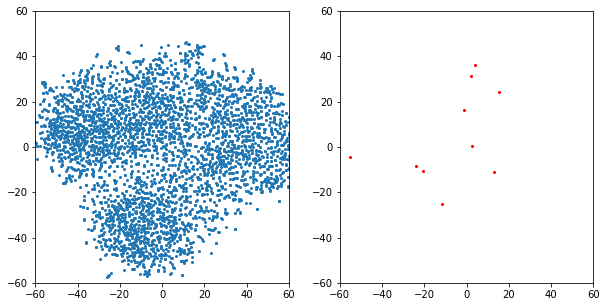

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(z_embedded[:len(dataset), 0], z_embedded[:len(dataset), 1], s=4)
ax[1].scatter(z_embedded[len(dataset):, 0], z_embedded[len(dataset):, 1], s=4, c='red')

for ax_ in ax:
    ax_.set_xlim(-60, 60)
    ax_.set_ylim(-60, 60)

plt.show()

Find closest original trajectories

In [16]:
Xg = x_sim.T
Xr = x.T
print(f"X generated: {Xg.shape}")
print(f"X real: {Xr.shape}")

X generated: torch.Size([32, 10])
X real: (32, 3968)


In [17]:
diff = (Xg[np.newaxis,...] - Xr[np.newaxis,...].T)
D = np.sqrt((diff**2).sum(1)).T
originals_idx = np.argmin(D, axis=1)

In [18]:
originals, _, info = dataset[originals_idx]
originals = torch.transpose(originals, 1, 2)
originals.size()

torch.Size([10, 200, 4])

In [19]:
data = originals.detach().numpy()
data = data.reshape((data.shape[0], -1))
data = dataset.scaler.inverse_transform(data)

In [20]:
data = np.concatenate((info, data), axis=1)
builder = model.get_builder(data.shape[0])
features = [
    "track" if "track" in f else f for f in model.hparams.features
]
traffic_original = traffic_from_data(
    data, features, model.hparams.init_features, builder=builder
)

if "track" not in traffic_original.data.columns:
    traffic_original = traffic_original.cumulative_distance().eval(desc="")

traffic_original

  0%|          | 0/10 [00:00<?, ?it/s]

,count
flight_id,
0,200
1,200
2,200
3,200
4,200
5,200
6,200
7,200
8,200


Decode generated samples

In [21]:
outputs = model.decoder(torch.Tensor(x_sim))
outputs = torch.transpose(outputs, 1, 2)
outputs.size()

torch.Size([10, 200, 4])

In [22]:
data = outputs.detach().numpy()
data = data.reshape((data.shape[0], -1))
data = dataset.scaler.inverse_transform(data)

In [23]:
# add latitude longitude info
data = np.concatenate((info, data), axis=1)
builder = model.get_builder(data.shape[0])
features = [
    "track" if "track" in f else f for f in model.hparams.features
]
traffic_generated = traffic_from_data(
    data, features, model.hparams.init_features, builder=builder
)

if "track" not in traffic_generated.data.columns:
    traffic_generated = traffic_generated.cumulative_distance().eval(desc="")

traffic_generated

  0%|          | 0/10 [00:00<?, ?it/s]

,count
flight_id,
0,200
1,200
2,200
3,200
4,200
5,200
6,200
7,200
8,200


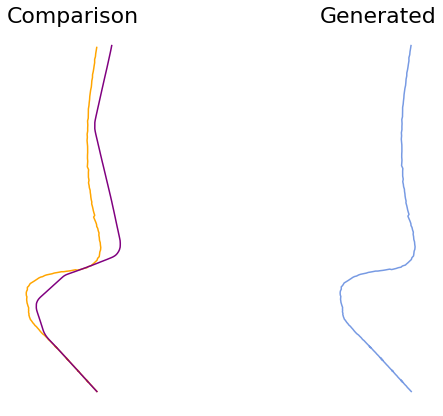

In [30]:
flight_id = 1
generated = traffic_generated[str(flight_id)]
original = traffic_original[str(flight_id)]
    
with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=EuroPP()))
    ax[0].set_title("Comparison")
    generated.plot(ax[0], c="orange", label="generated")
    original.plot(ax[0], c="purple", label="closest original")
    ax[1].set_title("Generated")
    generated.plot(ax[1])

    plt.show()

In [25]:
generated.chart().encode(alt.Y("compute_track"), alt.X("timestamp"), alt.Color("flight_id"))

alt.Chart(...)

In [26]:
generated.chart().encode(alt.Y("compute_gs"), alt.X("timestamp"), alt.Color("flight_id"))

alt.Chart(...)

In [27]:
generated.chart().encode(alt.Y("altitude"), alt.X("timestamp"), alt.Color("flight_id"))

alt.Chart(...)

Save generated trajectories into csv file

In [28]:
traffic_generated.to_csv("./outputs/vae_gen.csv")